In [112]:
%load_ext autoreload
%autoreload 2

import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../src/')
from simple_transformer import MultilayerTransformer, initialize_weights, train_model
from markov_utilities import (
    calculate_sequence_probabilities,
    compute_myopic_entropy_from_MSP,
    epsilon_machine_to_graph,
    get_recurrent_subgraph,
    to_mixed_state_presentation,
    get_recurrent_subgraph,
    calculate_empirical_sequence_probabilities,
    create_transition_matrix
)


from entropy_analysis import (
    compute_conditional_entropy,
    compute_empirical_conditional_entropy,
    inverse_binary_entropy,

)

from error_analysis import (
    compute_minimum_error,
)



from visualization import visualize_graph
from processes import RRXORProcess, GoldenMeanProcess, ZeroOneRProcess, EvenProcess


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The 0-1-Random Process

## Visualizing the Epsilon Machine
Let's start with visualizing the Epsilon Machine

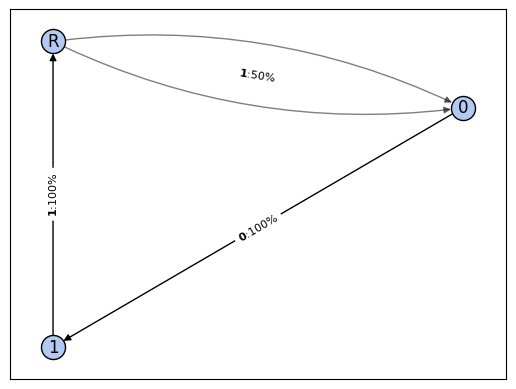

In [114]:
Z1R = ZeroOneRProcess()

# visualize the epsilon machine
graph = epsilon_machine_to_graph(Z1R.T, Z1R.state_names)
visualize_graph(graph, layout="spectral", draw_mixed_state=True, pdf="zero_one_r_epsilon.pdf")


## Mixed State Presentation

now let's compute the mixed state presentation and visualize it

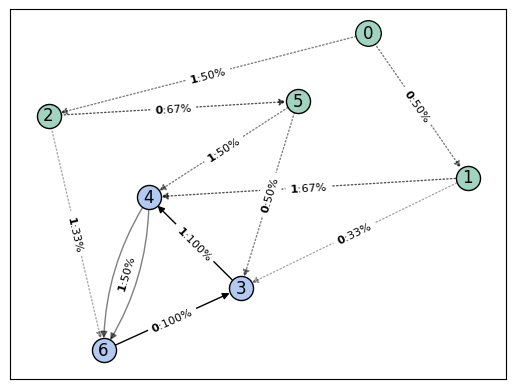

In [115]:
MSP = to_mixed_state_presentation(Z1R.T, threshold=1e-5)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph(G_MSP, layout='spring', draw_edge_labels=True,
                                      draw_mixed_state=True, draw_color=False, pdf="zero_one_r_msp.pdf")

now let's extract the recurrent part of the MSP, hopefully this should leave us with a HMM that is isomorphic to the original process

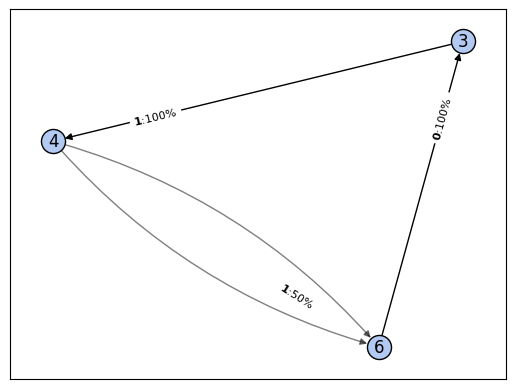

In [5]:
recurrent_subgraph = get_recurrent_subgraph(G_MSP)
visualize_graph(recurrent_subgraph,  draw_edge_labels=True, draw_mixed_state=True, draw_color=False)

## Myopic Entropy

plot the myopic entropy diagram

Text(0.5, 1.0, '01R) Myopic Entropy')

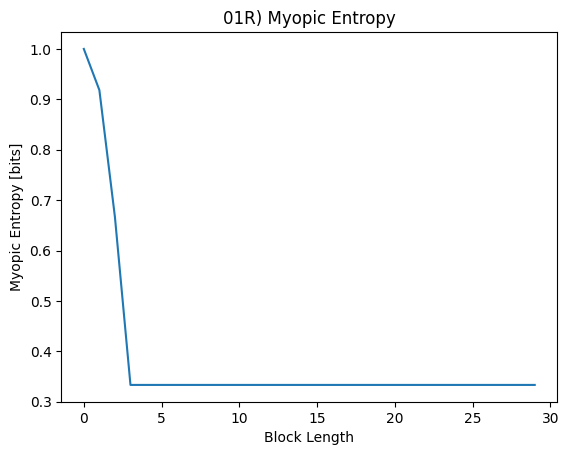

In [60]:
# myopic entropy
plt.plot(compute_myopic_entropy_from_MSP(MSP,30))
plt.ylabel('Myopic Entropy [bits]'); plt.xlabel('Block Length'); plt.title('01R) Myopic Entropy')

## Length-L word Distribution

Now we will compute word distributions at different lengths

In [81]:
import pandas as pd
seq_probs = calculate_sequence_probabilities(Z1R.T, 20)
data = []
for length, sequences in seq_probs.items():
    for sequence, probability in sequences.items():
        data.append({'length': length, 'sequence': sequence, 'probability': probability})

df = pd.DataFrame(data)
df.query('length == 2').sort_values('probability', ascending=False).head(10)

,length,sequence,probability
3,2,10,0.333333
2,2,01,0.333333
5,2,00,0.166667
4,2,11,0.166667


In [82]:
def calculate_probabilities(df, length):
    # Get the length and length + 1 data
    df_length = df[df['length'] == length]
    df_length_plus_one = df[df['length'] == length + 1]

    # Initialize a dictionary to store the probabilities
    probabilities = {'sequence': [], 'prob(0)': [], 'prob(1)': []}

    # For each length sequence
    for sequence in df_length['sequence']:
        # Get the probabilities of emitting a 0 or a 1 from the length + 1 data
        prob_0 = df_length_plus_one['probability'][df_length_plus_one['sequence'].str.startswith(sequence + '0')].sum()
        prob_1 = df_length_plus_one['probability'][df_length_plus_one['sequence'].str.startswith(sequence + '1')].sum()
        
        # Normalize the probabilities so they sum to 1
        total_prob = prob_0 + prob_1
        if total_prob > 0:
            prob_0 /= total_prob
            prob_1 /= total_prob
        
        # Add the probabilities to the dictionary
        probabilities['sequence'].append(sequence)
        probabilities['prob(0)'].append(prob_0)
        probabilities['prob(1)'].append(prob_1)

    # Convert the dictionary to a DataFrame
    df_new = pd.DataFrame(probabilities)
    #sort the dataframe by the probability of emitting a 0
    df_new = df_new.sort_values('prob(0)', ascending=False)
    return df_new

df_new = calculate_probabilities(df, 1)
df_new

,sequence,prob(0),prob(1)
1,1,0.666667,0.333333
0,0,0.333333,0.666667


## Building Processes from length-L histories

If we build a process using length 3 histories as states, what does that look like, what does the MSP look like, and what does the recurrent portion of the MSP look like?


The length-3 world length process has this many states:  6  and looks like this: 


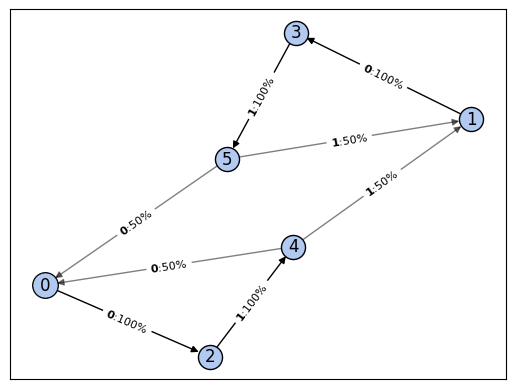

the MSP has this many states:  11  and looks like this: 


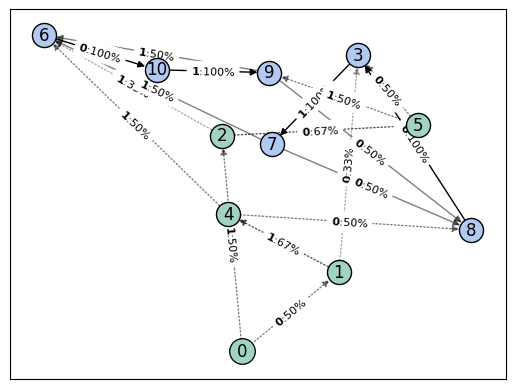

the recurrent subgraph has this many states:  6  and looks like this: 


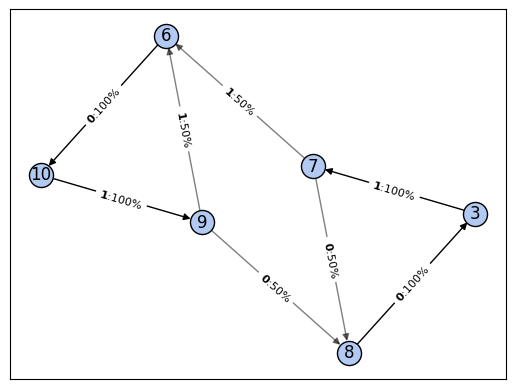

In [93]:
state_names, T, eprobs = create_transition_matrix(seq_probs,3 )
G = epsilon_machine_to_graph(T)
print("The length-3 world length process has this many states: ", len(state_names), " and looks like this: ")
visualize_graph(G, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True, pdf="zero_one_r_length_2.pdf")
MSP = to_mixed_state_presentation(T, threshold=1e-1)
print("the MSP has this many states: ", MSP.shape[1], " and looks like this: ") 
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph(G_MSP, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True, pdf="zero_one_r_msp_length_2.pdf")
recur = get_recurrent_subgraph(G_MSP)
print("the recurrent subgraph has this many states: ", len(recur.nodes), " and looks like this: ")
visualize_graph(recur, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

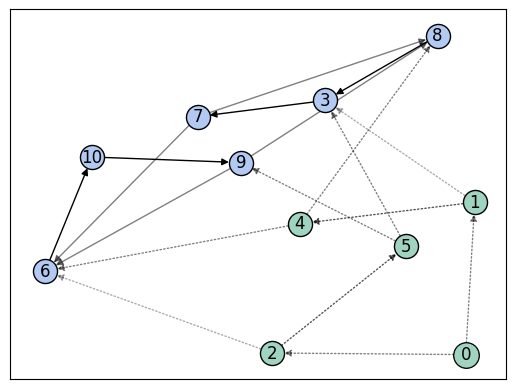

In [109]:
visualize_graph(G_MSP, layout='spring', draw_edge_labels=False, draw_color=False, draw_mixed_state=True, pdf="zero_one_r_msp_length_2.pdf")


## MSP of the MSP? why not

the MSP of the MSP has this many states:  11  and looks like this: 


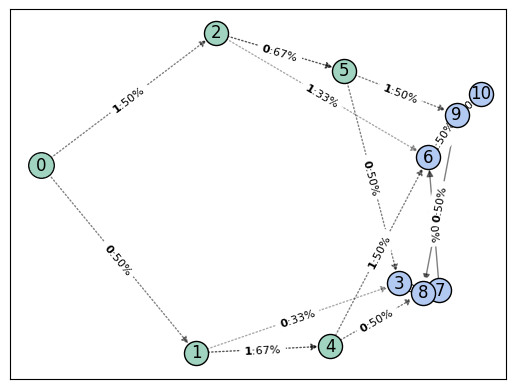

the recurrent subgraph has this many states:  6  and looks like this: 


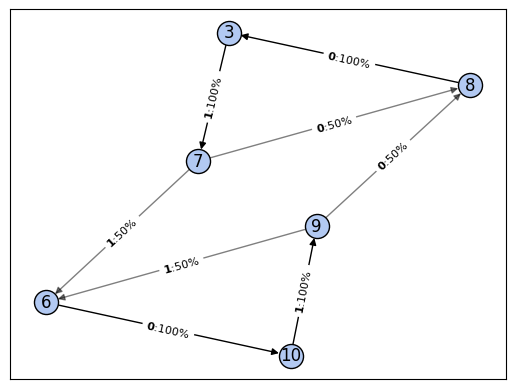

In [18]:
# make an MSP of the MSP
MSP_MSP = to_mixed_state_presentation(MSP, threshold=1e-5)
print("the MSP of the MSP has this many states: ", MSP_MSP.shape[1], " and looks like this: ")
G_MSP_MSP = epsilon_machine_to_graph(MSP_MSP)
visualize_graph_with_selective_offset(G_MSP_MSP, layout='spectral', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
# get recurrent
recurrent_subgraph = get_recurrent_subgraph(G_MSP_MSP)
print("the recurrent subgraph has this many states: ", len(recurrent_subgraph.nodes), " and looks like this: ")
visualize_graph_with_selective_offset(recurrent_subgraph, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

## Creating data, feeding it into a Transformer to Train

In [116]:
# Define a config for the transformer and training
config = {
    # transformer config
    'd_vocab': 2,
    'd_model': 16,
    'input_size': 10,  # context length
    'd_head': 16,
    'n_head': 4,
    'd_mlp': 4*16,
    'n_layers': 4,
    # training config
    'batch_size': 32,
    'sequence_length': 5000,
    'num_epochs': 100,
    'learning_rate': 1.5e-2,
    'weight_decay': 0.0,
    'patience': 1000,
    'factor': 0.5
}

# Generate sequence data with positions
train_loader, test_loader, sequence_positions = Z1R.prepare_data(config['sequence_length'], config['input_size'],
                                                                   split_ratio=0.8, batch_size=config['batch_size'],
                                                                   with_positions=True)

print(f"The number of batches in the training set is {len(train_loader)}")

# Model Definition
model = MultilayerTransformer(d_vocab=config['d_vocab'], d_model=config['d_model'], input_size=config['input_size'], 
                              d_head=config['d_head'], n_head=config['n_head'], d_mlp=config['d_mlp'], n_layers=config['n_layers'])
model.apply(initialize_weights)

# Check if CUDA is available and move the model to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
print('CUDA Available:', torch.cuda.is_available())

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config['patience'], factor=config['factor'], verbose=True)

# Training
model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=config['num_epochs'], verbose=True)

The number of batches in the training set is 125
CUDA Available: True
| Epoch | Training Acc. | Loss | Overall Acc. | Last Bit Acc. |
|   1   |    64.60%    |    0.4841     |      71.73%       |      77.57%      |
|   2   |    82.94%    |    0.3692     |      76.52%       |      82.29%      |
|   3   |    83.60%    |    0.3534     |      77.70%       |      83.17%      |
|   4   |    83.38%    |    0.3039     |      80.44%       |      83.69%      |
|   5   |    83.98%    |    0.3025     |      79.81%       |      83.27%      |
|   6   |    83.53%    |    0.3164     |      80.63%       |      82.91%      |
|   7   |    83.86%    |    0.2972     |      80.11%       |      83.30%      |
|   8   |    84.28%    |    0.2957     |      79.70%       |      82.62%      |
|   9   |    83.59%    |    0.3024     |      80.29%       |      84.18%      |
|  10   |    83.59%    |    0.2891     |      79.51%       |      81.97%      |
|  11   |    83.54%    |    0.2975     |      80.33%       |      

In [117]:
# define loss function as cross entropy loss, but no reduction
crossEntropy = nn.CrossEntropyLoss(reduction='none')

model.eval()
with torch.no_grad():
    # For train data
    train_loss = []
    train_accuracy = []
    for data, target in train_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        loss = crossEntropy(output.view(-1, 2), target.view(-1))
        # Reshape loss back to original shape before saving
        train_loss.append(loss.view(data.shape[0], data.shape[1]).cpu().numpy())
        # prediction is argmax over last dimension, which is 2
        pred = output.data.max(2, keepdim=True)[1]
        correct = pred.squeeze() ==  data
        train_accuracy.append(correct.cpu().numpy())

    # For test data
    test_loss = []
    test_accuracy = []
    for data, target in test_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        loss = crossEntropy(output.view(-1, 2), target.view(-1))
        test_loss.append(loss.view(data.shape[0], data.shape[1]).cpu().numpy())
        pred = output.data.max(2, keepdim=True)[1]
        correct = pred.squeeze() ==  data
        test_accuracy.append(correct.cpu().numpy())


train_loss = np.concatenate(train_loss)
train_accuracy = np.concatenate(train_accuracy)
test_loss = np.concatenate(test_loss)
test_accuracy = np.concatenate(test_accuracy)

print('Train Loss: ', np.mean(train_loss))
print('Train Accuracy: ', np.mean(train_accuracy))
print('Test Loss: ', np.mean(test_loss))
print('Test Accuracy: ', np.mean(test_accuracy))



Train Loss:  0.29361832
Train Accuracy:  0.3970190380761523
Test Loss:  0.29609317
Test Accuracy:  0.40080160320641284


In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# make the seaborn context prettier
sns.set_context('talk')


# Reshape the data to long format
train_loss_df = pd.DataFrame(train_loss).melt(var_name='context_position', value_name='loss')
train_loss_df['type'] = 'train'
test_loss_df = pd.DataFrame(test_loss).melt(var_name='context_position', value_name='loss')
test_loss_df['type'] = 'test'

# add 1 to context pos
train_loss_df['context_position'] += 1
test_loss_df['context_position'] += 1

# convert to bits from nats
train_loss_df['loss'] = np.log2(np.exp(train_loss_df['loss']))
test_loss_df['loss'] = np.log2(np.exp(test_loss_df['loss']))

# Concatenate the dataframes
loss_df = pd.concat([train_loss_df, test_loss_df])

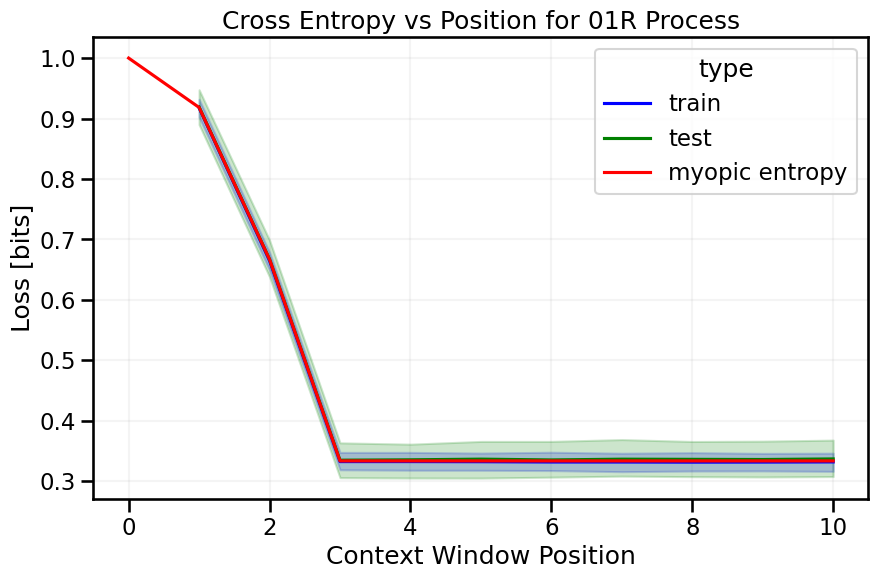

In [120]:
# Compute myopic entropy
myopic_entropy = compute_myopic_entropy_from_MSP(MSP,11)

# Create a DataFrame for myopic entropy
myopic_entropy_df = pd.DataFrame({
    'context_position': np.arange(len(myopic_entropy)),
    'loss': myopic_entropy,
    'type': 'myopic entropy'
})

# Concatenate the dataframes
loss_df = pd.concat([train_loss_df, test_loss_df, myopic_entropy_df])

# Define colors for each line
colors = {'train': 'blue', 'test': 'green', 'myopic entropy': 'red'}

# Plot using seaborn
plt.figure(figsize=(10, 6))
plt.grid(True)  # Add a grid for better readability
# make grid lighter
plt.gca().set_axisbelow(True)
plt.grid(which='major', color='#999999', linestyle='-', alpha=0.1)
sns.lineplot(data=loss_df, x='context_position', y='loss', hue='type', palette=colors)
plt.ylabel('Loss [bits]')
plt.xlabel('Context Window Position')
plt.title('Cross Entropy vs Position for 01R Process')
plt.show()